# Comparing Dropout Rates

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import matplotlib.pyplot as plt

In [66]:
# # # You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

/home/garg/miniconda3/envs/weatherbench/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [67]:
# tf.compat.v1.disable_eager_execution() #needed
tf.__version__

'2.0.0'

In [68]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
datadir='/home/garg/data/WeatherBench/5.625deg'
pred_save_dir='/home/garg/data/WeatherBench/predictions'
#start_date='2017-01-01'; end_date='2017-03-31'
start_date='2017-01-01'; end_date='2017-12-31'

In [69]:
    exp_id_path='/home/garg/WeatherBench/nn_configs/B/81-resnet_d3_dr_0.1.yml'
    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars']    
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years']
    lead_time=args['lead_time'] 

In [8]:
preds_p=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [9]:
#deterministic
#data
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])
mean = xr.open_dataarray(f'{model_save_dir}/{exp_id}_mean.nc') 
std = xr.open_dataarray(f'{model_save_dir}/{exp_id}_std.nc')

if (start_date and end_date)!=None:
    ds_test=ds.sel(time=slice(start_date,end_date))
else:
    ds_test= ds.sel(time=slice(test_years[0],test_years[-1]))  

dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, shuffle=False, 
                        load=True,mean=mean, std=std, output_vars=output_vars, nt_in=nt_in, 
                        dt_in=dt_in, data_subsample = data_subsample) 

#model
saved_model_path=f'{model_save_dir}/{exp_id}.h5'
substr=['resnet','unet_google','unet']
assert any(x in exp_id for x in substr)

model=tf.keras.models.load_model(saved_model_path,
                                 custom_objects={'PeriodicConv2D':PeriodicConv2D,'lat_mse': tf.keras.losses.mse})

preds = model.predict(dg_test, verbose=1) #deterministic
preds=preds* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

DG start 11:09:01.952065
DG normalize 11:09:01.966191
DG load 11:09:01.971557
Loading data into RAM
DG done 11:09:09.954530
136/136 [==============================] - 23s 167ms/step


In [10]:
preds.shape, preds.dtype

((4342, 32, 64, 2), dtype('float64'))

In [11]:
#numpy -->xarray
preds_d = xr.Dataset()
for i,var in enumerate(output_vars):
    da= xr.DataArray(preds[...,i], 
                     coords={
                             'time': dg_test.valid_time,
                             'lat': dg_test.data.lat, 'lon': dg_test.data.lon,}, 
                     dims=['time','lat', 'lon'])
    preds_d[var]=da

In [12]:
preds_d=xr.Dataset.expand_dims(preds_d,'member')

In [13]:
preds_d

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 1, time: 4342)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Dimensions without coordinates: member
Data variables:
    z_500    (member, time, lat, lon) float64 5.092e+04 5.093e+04 ... 4.899e+04
    t_850    (member, time, lat, lon) float64 257.0 256.9 256.9 ... 249.1 249.1

In [14]:
preds_p

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 100, time: 4342)
Coordinates:
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) datetime64[ns] 2017-01-04T04:00:00 ... 2017-12-31T22:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 ...
    t_850    (member, time, lat, lon) float64 ...

In [15]:
preds_p.z_500.values[0,0,0,0], preds_p.t_850.values[0,0,0,0] #checking units

(50877.623626030865, 256.2645588282184)

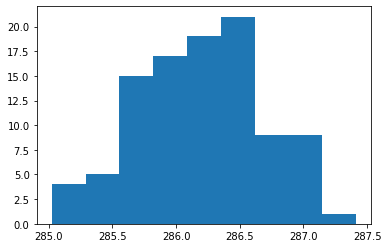

In [16]:
_=plt.hist(preds_p.t_850.isel(lat=20,lon=30,time=2), bins='auto')
plt.show()

# Getting Observations

In [70]:
z500_valid = load_test_data(f'{datadir}/geopotential_500', 'z')
t850_valid = load_test_data(f'{datadir}/temperature_850', 't')

observation=xr.Dataset()
observation['z_500']=z500_valid
observation['t_850']=t850_valid

observation=observation.astype('float64')
observation=observation.drop('level')

In [71]:
observation

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z_500    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    t_850    (time, lat, lon) float64 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>

In [72]:
observation.z_500.values[0,0,0],observation.t_850.values[0,0,0]

(50954.625, 257.8413391113281)

In [20]:
obs=observation.sel(time=preds_p.time)

In [21]:
obs.t_850.isel(lat=20,lon=30,time=2).values

array(286.24569702)

# Rmse

In [29]:
#RMSE 100 forecasts, 2017 year.
ensemblemean=preds_d.mean('member')
mean_rmse_d=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse_d)

ensemblemean=preds_p.mean('member')
mean_rmse_p=compute_weighted_rmse(observation,ensemblemean).load(); print(mean_rmse_p)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 315.5
    t_850_rmse  float64 1.826
<xarray.Dataset>
Dimensions:     ()
Data variables:
    z_500_rmse  float64 317.9
    t_850_rmse  float64 1.837


In [22]:
#Different ensemble sizes
mean_rmse=[]
for size in [20,50,100]:
    ens_mean=preds_p.sel(member=slice(None,size-1)).mean('member')
    mean_rmse.append(compute_weighted_rmse(obs,ens_mean))

In [23]:
for i in range(3):
    print(mean_rmse[i].z_500_rmse.values,  mean_rmse[i].t_850_rmse.values)

#determinstic
mean_rmse_d=compute_weighted_rmse(observation,preds_d.mean('member')).load(); 
print(mean_rmse_d.z_500_rmse)

318.9143750865319 1.841716188258986
318.1523146880202 1.8384180774840548
317.87133596766023 1.8373665489618554
<xarray.DataArray 'z_500_rmse' ()>
array(315.48041127)


In [ ]:
#So deterministic better?  
# not much advantage of bigger ensemble size in rmse?

# Comparing among dropout rates

In [73]:
exp_id='80-resnet_d3_dr_0.05'
preds_1=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='81-resnet_d3_dr_0.1'
preds_2=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

exp_id='82-resnet_d3_dr_0.2'
preds_3=xr.open_dataset(f'{pred_save_dir}/{exp_id}.nc')

In [55]:
preds_1.z_500.shape, preds_1.z_500.values[0,0,0,0],preds_2.z_500.values[0,0,0,0] #checking

((100, 4342, 32, 64), 51144.479085007035, 50877.623626030865)

In [37]:
mean_spread = []
mean_error = []

for ds in [preds_1, preds_2, preds_3]:
    ds=ds.chunk({'time': 500})
    mean_spread.append(compute_weighted_meanspread(ds).load())
    ens_mean = ds.mean('member')
    mean_error.append(compute_weighted_rmse(ens_mean, obs).load())

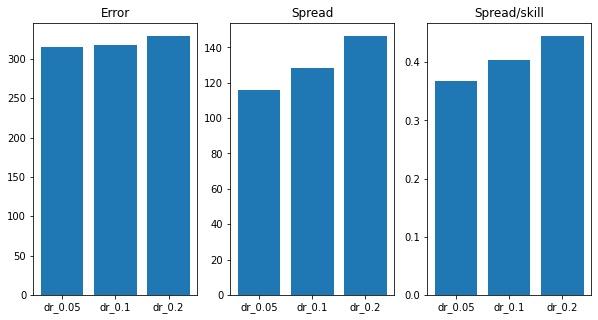

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
ax1.bar(['dr_0.05', 'dr_0.1', 'dr_0.2'], [ds.z_500_rmse for ds in mean_error])
ax2.bar(['dr_0.05', 'dr_0.1', 'dr_0.2'], [ds.z_500_mean_spread for ds in mean_spread])
ax3.bar(['dr_0.05', 'dr_0.1', 'dr_0.2'], [ds1.z_500_mean_spread / ds2.z_500_rmse 
                                   for ds1, ds2 in zip(mean_spread, mean_error)])
ax1.set_title('Error')
ax2.set_title('Spread')
ax3.set_title('Spread/skill');

In [45]:
for i in range(3):
    print(mean_error[i].z_500_rmse.values)
    
#Determinsitic
mean_rmse_d=compute_weighted_rmse(observation,preds_d.mean('member')).load() 
print(mean_rmse_d.z_500_rmse)

315.3966900816391
317.87133596766
329.0320693530171
<xarray.DataArray 'z_500_rmse' ()>
array(315.48041127)


In [ ]:
#so increasing dropout increases error,but improves spread-skill.worse than deterministic in rmse.

In [27]:
#Spread-skill Grid
def spread_skill_grid(da_fc,da_true):
    weights_lat = np.cos(np.deg2rad(da_fc.lat))
    weights_lat /= weights_lat.mean()
    #spread
    var1=da_fc.var('member')
    spread= np.sqrt((var1*weights_lat).mean('time'))
    #rmse
    ens_mean=da_fc.mean('member')
    error = ens_mean - da_true
    rmse = np.sqrt(((error)**2 * weights_lat).mean('time'))
    skill=spread/rmse
    return skill

In [28]:
preds=preds_2.sel(member=slice(None,19))
skill=spread_skill_grid(preds,obs) #dropout=0.1

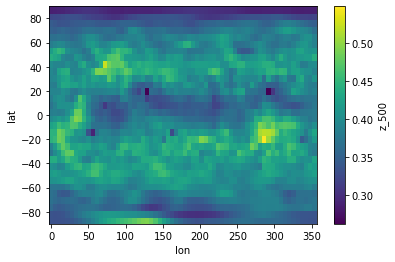

In [29]:
skill.z_500.plot()

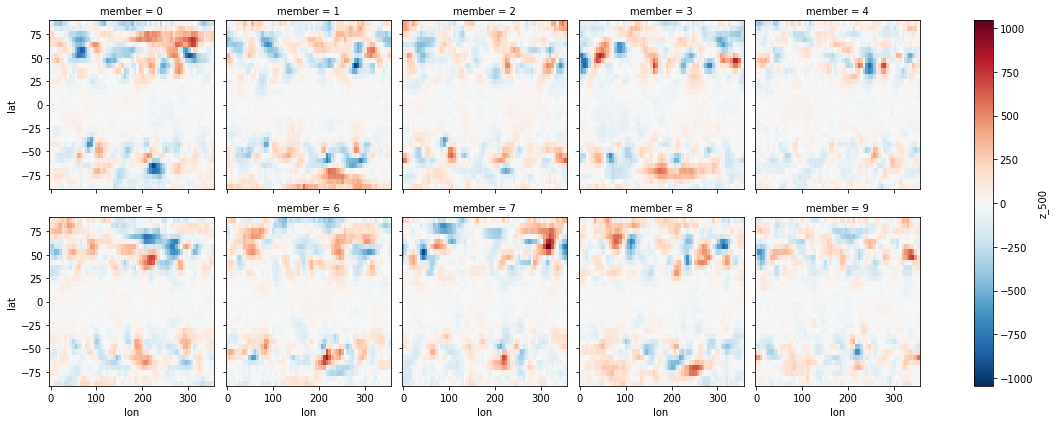

In [32]:
(preds.z_500.isel(time=0) - preds.z_500.isel(time=0).mean('member'))[:10].plot(col='member', col_wrap=5)

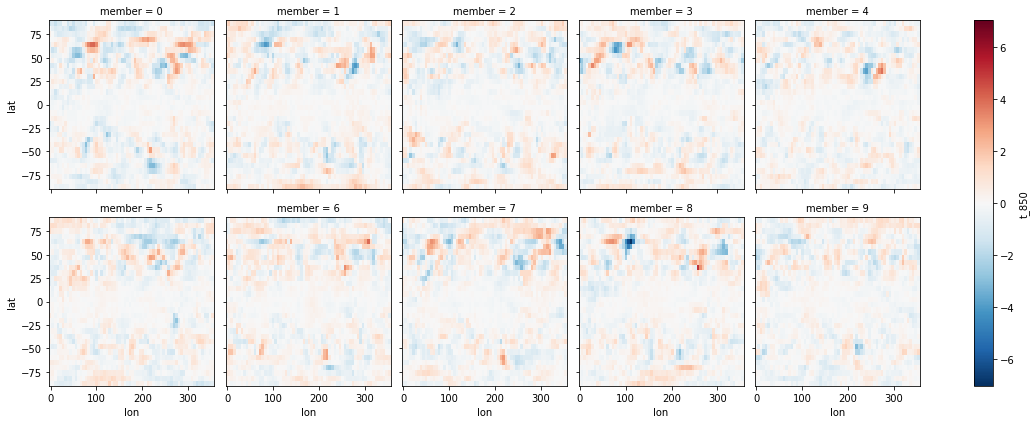

In [33]:
(preds.t_850.isel(time=0) - preds.t_850.isel(time=0).mean('member'))[:10].plot(col='member', col_wrap=5)

# CRPS

In [74]:
crps=[]
for ds in [preds_1, preds_2, preds_3]:
    preds=ds.sel(member=slice(None,19))
    crps.append(compute_weighted_crps(preds, observation).load())

In [75]:
for i in range(3):
    print(crps[i].z_500.values)

161.13053683631873
162.61370278898377
163.4442701135014


In [ ]:
#increasing dropout increases the spread ofcourse, but it is leading to worse rmse and crps.

In [76]:
#variation with ensemble size
crps_size=[]
for size in [10, 20, 30]:
    preds=preds_3.sel(member=slice(None,size-1))
    crps_size.append(compute_weighted_crps(preds, obs))

In [77]:
for i in range(3):
    print(crps_size[i].z_500.values)

166.77639487670172
163.4442701135014
162.33548629524282


In [ ]:
#so crps becomes better with ensemble size, which is okay.

In [82]:
#crps for determinstic. should be worse
crps_d=compute_weighted_crps(preds_d, observation)
crps_d.z_500.values

array(197.58159738)

In [ ]:
#crps for dtereminstic is worse. but rmse is better (or almost same as dr=0.05)

# Rank Histogram

In [37]:
#Method 3: Rank Histogram
from ranky import rankz

obs = np.asarray(obs.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

mask=np.ones(obs_z500.shape) #useless. #masked where 0/false.

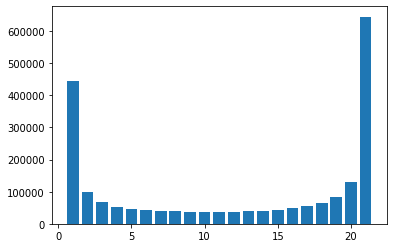

In [38]:
pred=np.asarray(preds_1.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

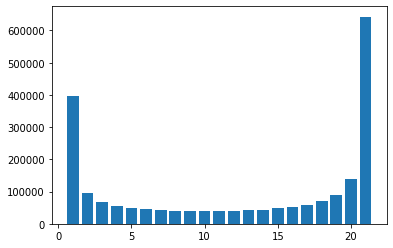

In [39]:
pred=np.asarray(preds_2.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

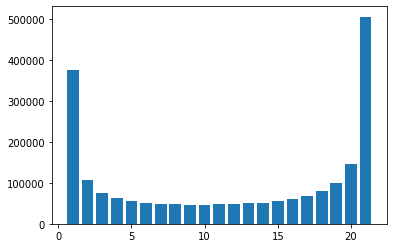

In [40]:
pred=np.asarray(preds_3.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)

#Rank histograms dont really tell much here. So I stick with 
#crps scores to compare among dropout rates
#rmse to compare among determinstic and probabilistic